# Dependencies

In [ ]:
!pip install tensorflow==1.15

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


# GAN

In [ ]:
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100
    optimizer = Adam(0.0002, 0.5) 
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    self.generator = self.build_generator()

    z = Input(shape=(self.latent_dim,))

    img , distance = self.generator(z)

    self.discriminator.trainable = False

    validity = self.discriminator(img)
    self.combined = Model(z, [validity, distance])
    self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=optimizer)
    
  def build_generator(self):
    #functional code
    input_layer = Input(shape=(self.latent_dim,))
    layer = Dense(256, activation=LeakyReLU(alpha=0.2))(input_layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(512, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(1024, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)

    out1 = Dense(np.prod(self.img_shape), activation='tanh' )(layer)
    out1 = Reshape(self.img_shape)(out1)

    out2 =  Dense(1, activation='sigmoid' )(layer)

    noise = input_layer
    img = out1
    distance = out2

    model = Model(noise, [img,distance])
    model.summary()
    return model

        
  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)

  def train(self, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    

    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
        
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs, distances = self.generator.predict(noise)
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)

      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      real_data_discrimination = []
      for i in range(0,len(imgs)):
        real_data_discrimination.append(1/(np.linalg.norm(imgs[0]))) 
      real_data_discrimination = np.array(real_data_discrimination)

      g_loss = self.combined.train_on_batch(noise, [valid,real_data_discrimination])
      

      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G loss: %f loss]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
      if epoch % sample_interval == 0:
        self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs, distances = self.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
      #fig.savefig("images/%d.png" % epoch)
      plt.close()

# Train

In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=26000, batch_size=64, sample_interval=1000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params:

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          25856       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256)          1024        dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          131584      batch_normalization_1[0][0]      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.836798, acc.: 33.59%] [G loss: 1.535544, G loss: 0.653757 loss]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
18570 [D loss: 0.647848, acc.: 64.06%] [G loss: 1.036832, G loss: 0.878163 loss]
18571 [D loss: 0.662699, acc.: 58.59%] [G loss: 1.087187, G loss: 0.928608 loss]
18572 [D loss: 0.657142, acc.: 57.03%] [G loss: 1.019983, G loss: 0.861228 loss]
18573 [D loss: 0.636854, acc.: 62.50%] [G loss: 1.018797, G loss: 0.858360 loss]
18574 [D loss: 0.615084, acc.: 67.19%] [G loss: 1.111782, G loss: 0.951131 loss]
18575 [D loss: 0.692769, acc.: 53.12%] [G loss: 1.097088, G loss: 0.938359 loss]
18576 [D loss: 0.729960, acc.: 50.00%] [G loss: 1.034829, G loss: 0.875216 loss]
18577 [D loss: 0.637928, acc.: 64.84%] [G loss: 1.048232, G loss: 0.887617 loss]
18578 [D loss: 0.605015, acc.: 69.53%] [G loss: 1.081203, G loss: 0.921553 loss]
18579 [D loss: 0.655495, acc.: 60.16%] [G loss: 1.104695, G loss: 0.944709 loss]
18580 [D loss: 0.624263, acc.: 66.41%] [G loss: 1.054205, G loss: 0.895430 loss]
18581 [D loss: 0.639203, acc.: 64.84%] [G loss: 1.023065, 

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          25856       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256)          1024        dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          131584      batch_normalization_1[0][0]      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.836798, acc.: 33.59%] [G loss: 1.535544, G loss: 0.653757 loss]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
23458 [D loss: 0.675689, acc.: 56.25%] [G loss: 1.076262, G loss: 0.916116 loss]
23459 [D loss: 0.603998, acc.: 64.84%] [G loss: 1.078549, G loss: 0.920179 loss]
23460 [D loss: 0.655311, acc.: 66.41%] [G loss: 1.066695, G loss: 0.906805 loss]
23461 [D loss: 0.628699, acc.: 61.72%] [G loss: 1.083463, G loss: 0.924983 loss]
23462 [D loss: 0.631621, acc.: 64.84%] [G loss: 1.056018, G loss: 0.895406 loss]
23463 [D loss: 0.737239, acc.: 52.34%] [G loss: 1.108452, G loss: 0.948811 loss]
23464 [D loss: 0.630494, acc.: 62.50%] [G loss: 1.101438, G loss: 0.942907 loss]
23465 [D loss: 0.663671, acc.: 57.81%] [G loss: 1.015973, G loss: 0.856881 loss]
23466 [D loss: 0.676938, acc.: 54.69%] [G loss: 1.054468, G loss: 0.897514 loss]
23467 [D loss: 0.685993, acc.: 53.12%] [G loss: 1.098521, G loss: 0.939070 loss]
23468 [D loss: 0.609649, acc.: 67.97%] [G loss: 1.148542, G loss: 0.991864 loss]
23469 [D loss: 0.598570, acc.: 67.19%] [G loss: 1.109412, 

# Visualize

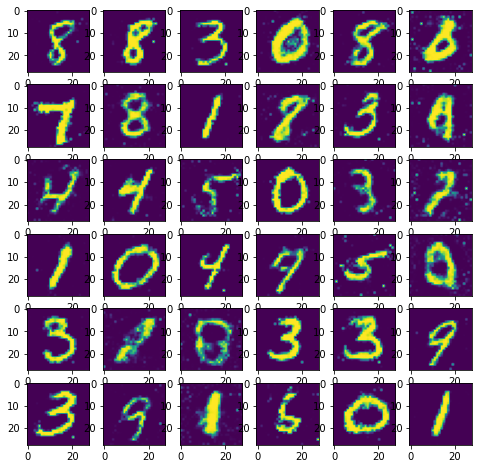

In [6]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,100))
gen_imgs , distance= gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

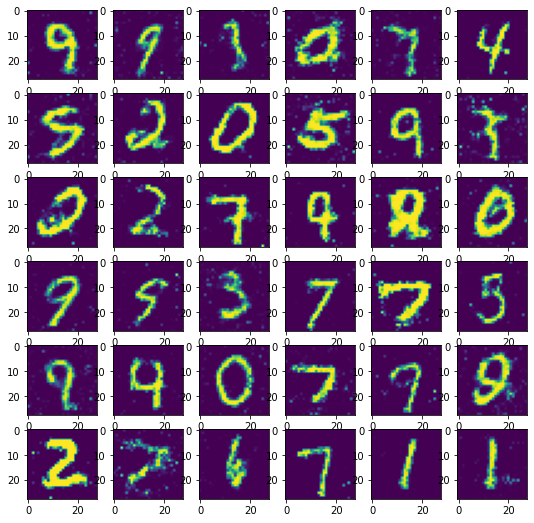

In [7]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,100))
gen_imgs, distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(9, 9))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

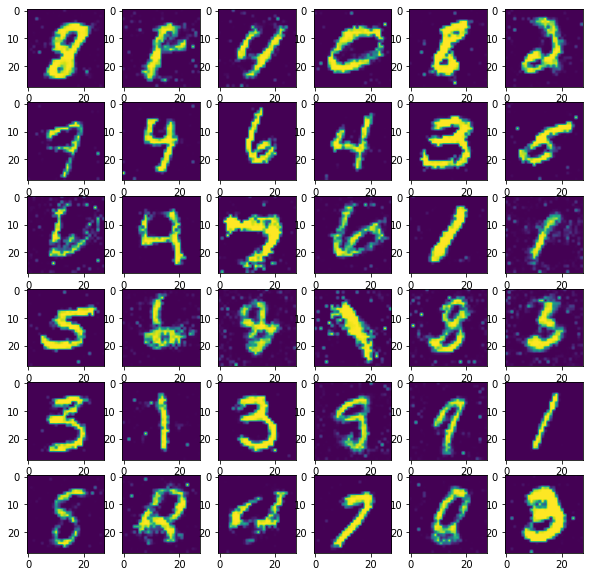

In [8]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (36,100))
gen_imgs , distance= gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 6
rows = 6
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

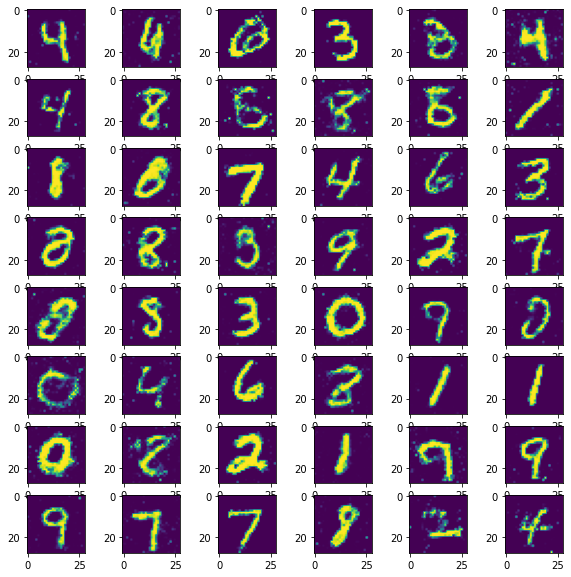

In [9]:
import matplotlib.pyplot as plt

noise = np.random.normal(0, 1, (48,100))
gen_imgs , distance= gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 6
rows = 8
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()